# シミュレーションの準備

In [1]:
include("../BPProblem.jl")
include("../BP.jl")
include("../AWGN.jl")
using Parameters


struct ProdBPProblem
    bpproblem::BPProblem
    Imax::Int
    alpha :: Float64
    Le :: Matrix{Float64}
    La :: Matrix{Float64}
    Lapp :: Matrix{Float64}
    Lch :: Matrix{Float64}
end

ProdBPProblem(N,K,mi,Imax,alpha) = begin
    t = BPProblem(N,K,mi)
    n = Int(log2(N))
    Le = zeros(N,N)
    La = zeros(N,N)
    Lapp = zeros(N,N)
    Lch = zeros(N,N)
    ProdBPProblem(t,Imax,alpha,Le,La,Lapp,Lch)
end

function initialize!(t::ProdBPProblem,ch::AWGN)
    updatellr!(ch)
    t.La .= zero(eltype(t.La))
    t.Le .= zero(eltype(t.Le))
    t.Lapp .= zero(eltype(t.Lapp))
    for i=1:ch.N
       t.Lch[i] = ch.llr[i]
    end
    nothing
end

function initialize_bp_row!(i,t::ProdBPProblem)
    x = t.bpproblem; F = x.polar.F
    @views initializeLandR!(x.L,x.R,F,t.Lch[i,:])
    @views x.L[:,end] .=  x.L[:,end] .+ t.La[i,:]
    nothing
end

function initialize_bp_column!(i,t::ProdBPProblem)
    x = t.bpproblem; F = x.polar.F
    k = F[i]
    @views initializeLandR!(x.L,x.R,F,t.Lch[:,k])
    @views x.L[:,end] .=  x.L[:,end] .+ t.La[:,k]
    nothing
end

function update_LLRmatrix!(t::ProdBPProblem)
    t.Le .= t.Lapp .- t.Lch .- t.La
    t.La .= t.alpha .*t.Le
    nothing
end

function polar_parity_check(v,F)
    polar_encoder_FN(v)
    for i in F
        if v[i] != 0
            return false
        end
    end
    return true
end

function iscodeword(v,t::ProdBPProblem)
    F = t.bpproblem.F
    #row
    for i=1:t.bpproblem.N
        for j=1.t.bpproblem.N
            v[i] = ifelse(Lapp[i,j] <= 0.0, 1,0)
        end
        if !polar_parity_check(v,F)
            return false
        end
    end

    #column
    for i=1:t.bpproblem.K
        for j=1.t.bpproblem.N
            v[i] = ifelse(Lapp[j,F[i]] <= 0.0, 1,0)
        end
        if !polar_parity_check(v,F)
            return false
        end
    end
    return true
end

function solver(sim,prodbpproblem::ProdBPProblem, ch::AWGN)
    @unpack bpproblem,Imax,alpha,Le,La,Lapp,Lch = prodbpproblem
    t = bpproblem; F = bpproblem.polar.F
    n = Int(log2(bpproblem.N))
    v = zeros(Int,bpproblem.N); u = zeros(Int,bpproblem.N)
    function checkcond()
        for i=1:bpproblem.N
            v[i] = harddecision(Int,bpproblem.L[i,end],bpproblem.R[i,end])
            u[i] = harddecision(Int,bpproblem.L[i,1],bpproblem.R[i,1])
        end
        Gcheck(u,v)
    end

    x = zeros(Int,bpproblem.N)
    iscodeword(::Type{ProdBPProblem}) = iscodeword(x,t)

    bler = 0; ber = 0; sucnt = 0; error = Int[]
    decoding_success_row = [false for i=1:bpproblem.N]
    decoding_success_column = [false for i=1:bpproblem.K]
    for s = 1:sim
        initialize!(prodbpproblem,ch)
        for _=1:Imax
            count = 0
            #row
            for i=1:bpproblem.N
                initialize_row!(i,prodbpproblem)
                success = BP(bpproblem.N,bpproblem.mi,bpproblem.L,bpproblem.R,bpproblem.M,checkcond)
                count += ifelse(success,0,1)
                update_Lapp!(prodbpproblem)
            end
            if iscodeword(ProdBPProblem)
                break
            end
            update_LLRmatrix!(prodbpproblem)

            #column
            for i=1:bpproblem.K
                initialize_column!(i,prodbpproblem)
                success = BP(bpproblem.N,bpproblem.mi,bpproblem.L,bpproblem.R,bpproblem.M,checkcond)
                count += ifelse(success,0,1)
                decoding_success_column[i] = success
                update_Lapp!(prodbpproblem)
            end
            if iscodeword(ProdBPProblem)
                break
            end
            update_LLRmatrix!(prodbpproblem)
        end

        tmp_error= errors(INFOBITS,prodbpproblem)
        if !iszero(tmp_error); push!(error,tmp_error); end
        ber += tmp_error
        @views if !isnothing(findfirst(<(0.0),prodbpproblem.Lapp[bpproblem.polar.A,bpproblem.polar.A]))
            bler += 1
        end
    end
    
    return bler/sim, ber/sim/ch.K, sucnt, error
end

solver (generic function with 1 method)

In [4]:
N = 16; K = 7
args = (N,K,200,20,0.5)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,5.0)
println(awgn)
@time res = solver(10000,t,awgn)

AWGN(256, 49, 5.0, -2.1804388528333583, 0.19140625, MersenneTwister(8), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

(0.2206, 0.011508163265306121, 9999, [2, 3, 3, 3, 5, 1, 3, 2, 1, 3  …  3, 3, 2, 3, 3, 2, 3, 1, 1, 5])

In [2]:
N = 16; K = 7
args = (N,K,200,20,0.5)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,3.0)
println(awgn)
@time res = solver(10000,t,awgn)

AWGN(256, 49, 3.0, -4.180438852833358, 0.19140625, MersenneTwister(8), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

(0.3347, 0.02010204081632653, 9993, [3, 5, 2, 10, 2, 1, 1, 5, 3, 3  …  8, 1, 5, 2, 1, 2, 4, 3, 3, 5])

In [37]:
N = 32; K = 21
args = (N,K,200,20,0.5)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,3.0)
println(awgn)
@time res = solver(10000,t,awgn)

AWGN(1024, 441, 3.0, -0.6586136717197344, 0.4306640625, MersenneTwister(8), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

(0.4125, 0.0038077097505668936, 9042, [2, 2, 4, 3, 8, 1, 2, 1, 3, 3  …  4, 7, 3, 6, 4, 5, 3, 9, 1, 4])

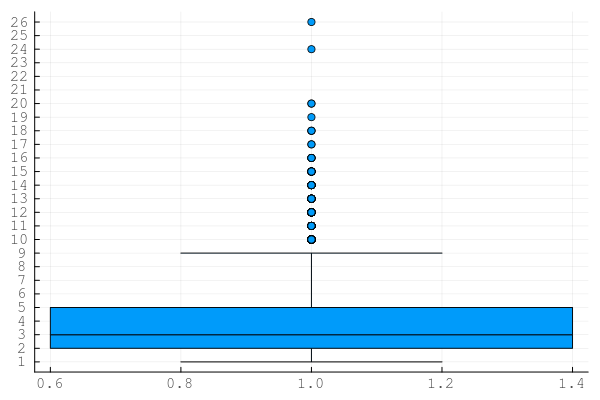

In [31]:
using StatsPlots
boxplot(res[4],label="",yticks = [1:30;])

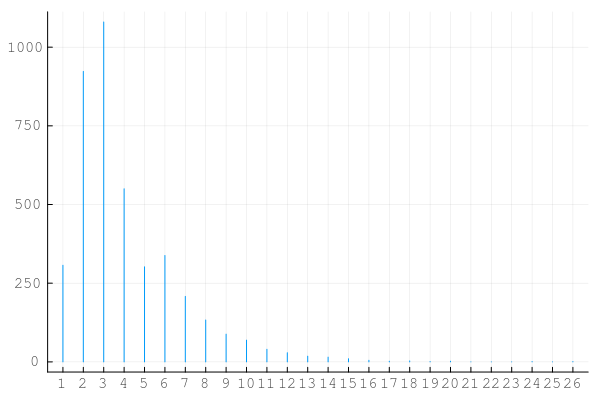

In [45]:
using Plots
function hindo(a)
    v = zeros(Int,maximum(a))
    for i in a
        v[i] += 1
    end
    v
end
e  = hindo(res[4])
plot(e,label="",xticks=[1:30;],line=:stem)

In [24]:
struct LOG
    filename :: String 
    data ::String
end

function write_log(l::LOG)
    filename = l.filename
    open(filename,"a") do f
        println(f,l.data)
    end
end

write_log (generic function with 1 method)

In [14]:
N = 32; K = 21
args = (N,K,100,20,0.5)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,3.0)
println(awgn)
@time res = solver(10000,t,awgn)

AWGN(1024, 441, 3.0, -0.6586136717197344, 0.4306640625, MersenneTwister(8), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

(0.4125, 0.0038077097505668936, 9042, [2, 2, 4, 3, 8, 1, 2, 1, 3, 3  …  4, 7, 3, 6, 4, 5, 3, 9, 1, 4])

In [7]:
N = 32; K = 21
args = (N,K,100,20,0.5)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,3.0)
println(awgn)
@time res = solver(10000,t,awgn)

AWGN(1024, 441, 3.0, -0.6586136717197344, 0.4306640625, MersenneTwister(8), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

(0.4125, 0.009058730158730158, 9042, [4, 4, 12, 4, 16, 4, 12, 8, 4, 4  …  8, 10, 4, 4, 7, 4, 4, 20, 12, 7])

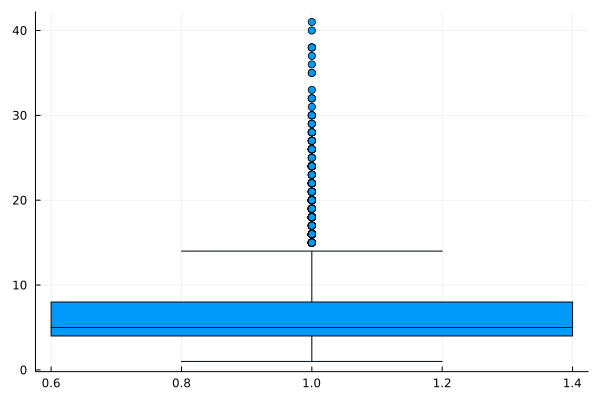

In [12]:
using StatsPlots
e = [4, 4, 12, 4, 16, 4, 12, 8, 4, 4, 8, 4, 4, 8, 4, 8, 3, 4, 4, 8, 12, 4, 8, 8, 4, 8, 4, 8, 8, 4, 4, 26, 2, 16, 8, 20, 4, 2, 4, 17, 20, 11, 10, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 7, 4, 4, 20, 4, 8, 8, 4, 4, 4, 8, 8, 4, 17, 4, 4, 8, 8, 4, 4, 4, 4, 4, 12, 4, 4, 4, 4, 8, 4, 21, 4, 12, 4, 7, 8, 4, 4, 14, 18, 4, 18, 8, 4, 21, 4, 4, 4, 4, 12, 6, 5, 4, 4, 8, 13, 8, 4, 4, 8, 8, 10, 4, 4, 4, 24, 4, 4, 12, 12, 4, 4, 4, 12, 8, 4, 4, 12, 8, 4, 8, 4, 4, 4, 8, 12, 5, 8, 4, 20, 8, 4, 4, 12, 4, 5, 6, 6, 4, 8, 4, 10, 4, 4, 4, 4, 16, 10, 12, 10, 4, 4, 10, 4, 4, 8, 4, 4, 4, 4, 8, 12, 12, 4, 8, 4, 4, 16, 8, 4, 4, 4, 8, 4, 8, 4, 8, 12, 20, 12, 4, 4, 12, 8, 8, 2, 4, 4, 16, 4, 6, 4, 18, 17, 8, 4, 8, 8, 8, 4, 12, 12, 11, 12, 4, 8, 16, 10, 11, 8, 10, 4, 8, 8, 12, 4, 4, 5, 4, 8, 8, 9, 5, 4, 4, 4, 8, 4, 4, 4, 4, 8, 4, 4, 8, 8, 2, 20, 8, 12, 4, 4, 18, 4, 4, 8, 4, 4, 8, 4, 8, 4, 4, 4, 6, 4, 12, 4, 4, 8, 4, 8, 8, 8, 6, 8, 9, 4, 12, 4, 12, 12, 10, 4, 12, 12, 4, 7, 4, 14, 4, 10, 4, 4, 8, 8, 24, 4, 4, 4, 4, 14, 8, 4, 18, 8, 4, 4, 12, 27, 4, 12, 7, 4, 4, 15, 8, 4, 4, 4, 4, 18, 4, 4, 12, 4, 4, 4, 10, 12, 16, 4, 8, 8, 4, 4, 4, 4, 12, 8, 9, 4, 4, 4, 4, 12, 4, 8, 4, 4, 8, 4, 4, 12, 4, 4, 4, 9, 8, 10, 4, 4, 4, 11, 4, 4, 6, 8, 4, 10, 22, 12, 4, 10, 8, 4, 7, 17, 4, 6, 4, 4, 8, 5, 8, 4, 8, 4, 1, 4, 16, 8, 10, 12, 4, 4, 4, 4, 4, 7, 4, 4, 10, 4, 8, 20, 10, 4, 4, 4, 4, 11, 4, 12, 25, 8, 8, 4, 4, 12, 9, 16, 4, 22, 4, 4, 12, 4, 8, 4, 4, 12, 28, 8, 4, 4, 8, 4, 12, 4, 4, 7, 24, 10, 4, 4, 4, 4, 4, 8, 4, 15, 9, 6, 4, 4, 4, 4, 14, 12, 8, 4, 2, 4, 8, 8, 19, 8, 9, 4, 20, 4, 4, 4, 16, 4, 16, 6, 8, 8, 37, 4, 12, 4, 11, 8, 6, 8, 4, 4, 12, 4, 18, 4, 4, 5, 12, 4, 4, 4, 4, 8, 4, 20, 4, 4, 13, 25, 8, 8, 10, 4, 10, 4, 4, 4, 4, 12, 8, 12, 12, 12, 4, 4, 6, 4, 10, 8, 8, 4, 8, 8, 26, 8, 4, 6, 4, 4, 19, 11, 4, 6, 10, 4, 12, 12, 4, 4, 4, 19, 16, 4, 28, 10, 4, 8, 8, 10, 5, 4, 10, 16, 4, 4, 4, 4, 4, 8, 4, 8, 9, 12, 4, 22, 8, 4, 12, 12, 4, 6, 12, 4, 10, 4, 4, 4, 6, 4, 4, 4, 4, 4, 8, 8, 12, 13, 4, 10, 8, 16, 4, 4, 17, 6, 4, 7, 4, 4, 4, 8, 2, 4, 8, 4, 12, 4, 8, 4, 4, 6, 12, 4, 4, 8, 4, 4, 21, 4, 4, 12, 4, 4, 20, 4, 4, 4, 4, 4, 12, 6, 12, 4, 8, 24, 8, 12, 4, 12, 4, 10, 4, 4, 8, 4, 4, 16, 4, 8, 4, 4, 15, 4, 4, 8, 8, 8, 13, 8, 4, 8, 19, 4, 4, 8, 4, 14, 6, 13, 21, 4, 4, 4, 4, 4, 8, 16, 18, 4, 4, 9, 12, 8, 7, 12, 12, 4, 4, 4, 8, 10, 4, 10, 8, 4, 4, 12, 4, 8, 4, 7, 4, 8, 8, 4, 8, 12, 12, 16, 4, 4, 4, 4, 4, 12, 8, 4, 4, 8, 4, 15, 4, 4, 12, 4, 4, 7, 4, 8, 8, 9, 8, 10, 15, 8, 8, 4, 8, 8, 8, 4, 12, 8, 6, 12, 4, 4, 4, 4, 12, 8, 8, 4, 4, 8, 4, 4, 13, 4, 15, 4, 8, 18, 9, 8, 4, 8, 4, 4, 4, 4, 4, 2, 4, 4, 8, 4, 8, 6, 4, 4, 4, 6, 4, 16, 12, 4, 8, 14, 4, 8, 4, 8, 12, 4, 8, 8, 15, 4, 4, 20, 8, 7, 12, 4, 8, 12, 4, 8, 4, 16, 4, 8, 6, 16, 12, 20, 2, 8, 4, 4, 4, 10, 4, 4, 16, 4, 4, 4, 6, 4, 4, 4, 8, 4, 6, 8, 12, 4, 6, 12, 5, 6, 8, 4, 12, 8, 8, 4, 4, 20, 4, 8, 12, 4, 4, 8, 4, 4, 4, 4, 8, 4, 8, 8, 8, 8, 30, 4, 8, 16, 10, 16, 4, 12, 4, 11, 4, 8, 16, 8, 4, 4, 5, 4, 4, 8, 14, 9, 4, 6, 8, 8, 4, 8, 4, 12, 9, 8, 4, 7, 4, 10, 4, 14, 8, 4, 4, 4, 10, 4, 4, 7, 9, 4, 13, 4, 4, 10, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 8, 4, 4, 23, 6, 4, 8, 4, 8, 4, 8, 22, 24, 25, 4, 16, 4, 8, 12, 17, 4, 27, 13, 4, 4, 4, 4, 4, 4, 5, 8, 12, 4, 16, 4, 8, 4, 12, 4, 12, 8, 4, 4, 4, 4, 8, 4, 8, 26, 11, 4, 12, 8, 4, 4, 8, 4, 4, 4, 8, 8, 16, 4, 12, 8, 16, 4, 8, 8, 4, 4, 4, 8, 12, 4, 8, 4, 6, 4, 4, 4, 4, 4, 8, 14, 8, 4, 16, 4, 8, 21, 12, 4, 16, 8, 26, 8, 4, 4, 4, 4, 2, 12, 4, 4, 4, 4, 8, 4, 4, 2, 4, 5, 8, 12, 4, 16, 30, 7, 21, 8, 8, 16, 4, 13, 12, 4, 4, 4, 4, 4, 20, 4, 10, 4, 4, 8, 12, 4, 4, 24, 9, 8, 8, 4, 4, 12, 4, 4, 4, 4, 12, 4, 4, 8, 4, 4, 20, 4, 4, 6, 8, 12, 4, 2, 8, 4, 12, 4, 11, 4, 18, 12, 12, 4, 14, 4, 4, 4, 4, 4, 4, 7, 4, 4, 12, 20, 9, 4, 4, 4, 4, 30, 12, 16, 35, 4, 8, 8, 12, 4, 4, 4, 11, 4, 4, 4, 4, 16, 24, 4, 4, 4, 4, 4, 11, 8, 4, 19, 8, 8, 4, 12, 4, 4, 10, 4, 4, 4, 4, 4, 4, 16, 8, 4, 7, 8, 4, 7, 10, 4, 4, 4, 20, 6, 4, 12, 6, 4, 8, 13, 4, 4, 4, 4, 4, 8, 5, 8, 4, 12, 3, 4, 4, 12, 8, 8, 2, 2, 20, 4, 4, 8, 4, 8, 8, 4, 4, 8, 8, 4, 4, 4, 4, 4, 12, 12, 8, 4, 12, 4, 4, 4, 4, 8, 4, 24, 8, 4, 10, 4, 4, 8, 11, 4, 6, 8, 4, 12, 5, 4, 16, 4, 4, 8, 4, 4, 6, 8, 4, 18, 20, 4, 8, 16, 4, 4, 4, 4, 4, 16, 13, 8, 8, 6, 8, 10, 4, 4, 22, 4, 4, 4, 4, 8, 6, 4, 4, 4, 4, 4, 8, 4, 12, 8, 4, 13, 4, 4, 4, 4, 14, 4, 16, 4, 4, 4, 4, 4, 8, 11, 8, 4, 4, 4, 12, 4, 8, 8, 4, 8, 4, 4, 4, 6, 4, 8, 12, 8, 16, 4, 4, 8, 4, 8, 12, 6, 4, 7, 10, 4, 4, 4, 12, 8, 12, 2, 8, 18, 4, 4, 4, 8, 14, 8, 4, 4, 4, 6, 8, 4, 4, 8, 4, 4, 4, 4, 4, 27, 8, 4, 9, 10, 8, 16, 10, 4, 4, 4, 4, 8, 4, 4, 4, 22, 4, 8, 10, 4, 4, 4, 4, 12, 4, 9, 4, 4, 4, 8, 4, 18, 4, 8, 8, 4, 4, 8, 4, 16, 12, 4, 4, 18, 4, 6, 16, 6, 4, 22, 4, 11, 4, 4, 4, 4, 8, 4, 16, 6, 16, 4, 8, 8, 8, 16, 11, 12, 4, 4, 4, 2, 8, 15, 4, 4, 8, 27, 6, 8, 4, 4, 4, 4, 4, 11, 8, 4, 8, 4, 8, 8, 4, 11, 4, 11, 4, 4, 4, 4, 4, 4, 13, 12, 4, 26, 4, 12, 8, 4, 8, 4, 12, 4, 8, 4, 10, 4, 10, 4, 4, 13, 8, 4, 4, 4, 4, 16, 4, 12, 3, 4, 12, 8, 12, 4, 12, 8, 4, 4, 4, 4, 6, 10, 4, 4, 12, 16, 4, 12, 8, 4, 12, 12, 8, 4, 12, 8, 4, 4, 18, 12, 8, 4, 4, 4, 4, 6, 4, 4, 4, 12, 20, 13, 12, 4, 4, 4, 4, 12, 4, 4, 4, 8, 8, 4, 6, 12, 4, 8, 4, 10, 4, 12, 12, 8, 7, 9, 4, 4, 12, 4, 4, 4, 8, 8, 6, 3, 4, 4, 6, 23, 24, 4, 4, 8, 4, 8, 8, 4, 12, 4, 4, 6, 4, 4, 8, 4, 4, 6, 8, 4, 8, 12, 4, 8, 4, 4, 4, 12, 8, 4, 4, 12, 4, 8, 4, 4, 4, 4, 4, 4, 8, 8, 8, 14, 18, 8, 12, 8, 8, 4, 18, 8, 4, 4, 4, 8, 16, 4, 4, 10, 8, 8, 8, 8, 11, 4, 4, 10, 6, 10, 10, 8, 12, 9, 4, 4, 3, 4, 6, 10, 8, 4, 16, 8, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 3, 6, 10, 12, 8, 4, 16, 6, 4, 4, 8, 8, 4, 8, 4, 4, 4, 4, 4, 4, 8, 4, 18, 4, 3, 4, 16, 4, 6, 11, 16, 4, 8, 9, 8, 8, 4, 4, 4, 16, 4, 4, 4, 4, 8, 2, 14, 24, 4, 7, 8, 24, 4, 8, 15, 4, 4, 4, 5, 4, 4, 8, 12, 4, 4, 8, 4, 4, 4, 12, 8, 4, 10, 20, 4, 8, 4, 4, 4, 7, 4, 12, 4, 6, 8, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 10, 4, 4, 10, 8, 4, 4, 8, 4, 4, 4, 3, 14, 11, 8, 8, 8, 8, 8, 8, 4, 4, 18, 4, 4, 4, 4, 6, 8, 2, 8, 22, 26, 12, 8, 4, 8, 9, 4, 14, 4, 26, 4, 4, 8, 4, 8, 4, 4, 4, 4, 4, 8, 12, 6, 4, 4, 8, 12, 4, 4, 6, 2, 4, 4, 12, 8, 4, 8, 4, 8, 18, 20, 10, 6, 19, 4, 17, 8, 18, 14, 4, 22, 4, 6, 4, 6, 8, 4, 8, 4, 8, 8, 4, 12, 10, 4, 4, 4, 4, 8, 4, 12, 8, 12, 12, 12, 8, 4, 6, 16, 18, 8, 4, 21, 10, 12, 18, 12, 12, 4, 12, 4, 8, 2, 4, 6, 4, 27, 12, 10, 4, 19, 4, 8, 6, 4, 4, 4, 4, 4, 4, 8, 8, 8, 18, 13, 4, 5, 8, 16, 10, 4, 4, 4, 8, 4, 4, 4, 4, 4, 8, 4, 10, 2, 4, 4, 4, 8, 16, 6, 4, 4, 16, 8, 15, 10, 4, 4, 9, 8, 4, 4, 6, 26, 4, 12, 6, 4, 8, 4, 4, 8, 4, 8, 4, 8, 4, 7, 4, 4, 4, 12, 15, 4, 6, 16, 4, 20, 4, 4, 4, 6, 20, 20, 8, 10, 4, 8, 4, 12, 9, 8, 4, 4, 8, 4, 8, 4, 4, 4, 4, 4, 7, 8, 4, 8, 8, 4, 4, 4, 4, 4, 8, 8, 12, 8, 4, 8, 8, 14, 2, 4, 8, 12, 4, 23, 8, 4, 4, 8, 4, 13, 4, 4, 12, 4, 4, 4, 7, 12, 4, 4, 8, 8, 4, 8, 18, 10, 4, 6, 8, 8, 21, 16, 4, 2, 4, 4, 4, 4, 4, 4, 4, 13, 8, 8, 8, 4, 4, 8, 4, 12, 8, 4, 9, 4, 4, 8, 4, 8, 4, 4, 8, 4, 8, 16, 4, 4, 4, 4, 8, 8, 6, 4, 4, 4, 4, 4, 4, 5, 10, 4, 4, 12, 13, 4, 4, 12, 4, 8, 4, 4, 4, 7, 4, 4, 4, 8, 4, 10, 12, 20, 12, 5, 4, 16, 12, 4, 16, 6, 12, 8, 4, 2, 4, 6, 4, 8, 4, 4, 12, 10, 4, 8, 4, 8, 4, 8, 12, 8, 4, 6, 4, 3, 4, 4, 4, 8, 4, 14, 11, 4, 8, 8, 14, 4, 6, 8, 6, 8, 8, 4, 5, 4, 4, 8, 4, 12, 4, 4, 8, 41, 4, 6, 12, 3, 4, 2, 8, 12, 14, 18, 8, 18, 8, 8, 4, 6, 4, 4, 9, 4, 9, 5, 4, 13, 4, 8, 14, 12, 4, 4, 4, 4, 4, 8, 8, 4, 8, 4, 7, 8, 4, 8, 8, 6, 4, 8, 4, 4, 4, 4, 13, 4, 8, 13, 4, 8, 12, 4, 8, 14, 4, 8, 4, 12, 8, 4, 4, 4, 4, 4, 4, 8, 8, 10, 4, 4, 8, 4, 8, 11, 8, 16, 13, 4, 12, 4, 12, 30, 4, 16, 4, 4, 18, 4, 9, 3, 8, 4, 4, 4, 4, 16, 12, 12, 8, 4, 6, 4, 12, 8, 4, 4, 4, 8, 7, 12, 4, 4, 6, 4, 4, 2, 8, 8, 12, 4, 6, 4, 5, 8, 4, 8, 4, 12, 8, 4, 13, 4, 4, 4, 4, 2, 8, 4, 2, 11, 6, 19, 8, 8, 4, 4, 12, 8, 12, 8, 4, 6, 8, 4, 12, 8, 4, 12, 4, 12, 4, 8, 4, 4, 4, 4, 4, 4, 4, 8, 8, 11, 3, 8, 4, 7, 10, 12, 4, 6, 12, 8, 4, 14, 28, 8, 8, 4, 7, 8, 4, 14, 8, 20, 4, 12, 4, 6, 13, 4, 12, 4, 4, 4, 8, 10, 14, 4, 5, 4, 4, 16, 4, 15, 4, 8, 4, 4, 9, 4, 12, 20, 4, 4, 4, 12, 4, 8, 4, 4, 4, 20, 10, 13, 4, 4, 4, 8, 8, 2, 8, 4, 8, 4, 4, 8, 4, 8, 4, 4, 12, 4, 22, 4, 4, 9, 4, 4, 8, 4, 4, 4, 4, 8, 4, 4, 8, 4, 8, 4, 4, 17, 6, 4, 13, 4, 4, 15, 4, 4, 4, 4, 16, 4, 14, 6, 4, 4, 4, 6, 12, 3, 12, 8, 8, 4, 4, 4, 18, 4, 12, 4, 4, 4, 4, 4, 4, 8, 11, 8, 4, 4, 20, 25, 3, 10, 8, 12, 2, 12, 26, 12, 2, 4, 12, 4, 4, 8, 12, 4, 12, 19, 8, 4, 4, 8, 4, 16, 22, 12, 3, 10, 4, 22, 12, 4, 10, 13, 8, 8, 4, 8, 4, 4, 19, 5, 4, 8, 4, 6, 4, 4, 4, 4, 4, 4, 24, 4, 4, 8, 4, 8, 4, 4, 4, 20, 14, 6, 22, 8, 4, 8, 2, 4, 5, 12, 8, 2, 12, 4, 4, 4, 4, 8, 11, 4, 19, 4, 13, 8, 4, 4, 16, 4, 8, 4, 24, 4, 4, 4, 4, 6, 4, 12, 4, 4, 10, 4, 8, 2, 4, 4, 16, 4, 4, 8, 4, 4, 4, 8, 4, 4, 8, 4, 13, 8, 4, 4, 4, 8, 8, 7, 8, 10, 8, 4, 4, 24, 12, 12, 9, 4, 14, 4, 4, 9, 4, 18, 12, 2, 8, 12, 4, 10, 12, 18, 6, 12, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 4, 4, 4, 8, 8, 8, 8, 4, 4, 8, 12, 4, 15, 8, 8, 18, 8, 4, 2, 9, 4, 18, 8, 8, 8, 4, 4, 4, 8, 8, 4, 10, 8, 6, 6, 4, 4, 4, 8, 4, 4, 4, 12, 4, 8, 4, 12, 8, 4, 13, 4, 4, 4, 8, 4, 6, 12, 5, 4, 4, 8, 4, 4, 12, 4, 4, 13, 4, 4, 8, 4, 10, 8, 4, 4, 14, 24, 6, 26, 8, 4, 4, 12, 10, 4, 2, 4, 8, 8, 8, 4, 12, 4, 4, 4, 4, 16, 16, 4, 8, 4, 4, 4, 12, 8, 12, 4, 4, 8, 8, 4, 8, 4, 4, 16, 4, 2, 4, 13, 4, 4, 6, 4, 8, 16, 8, 8, 4, 8, 12, 4, 32, 12, 12, 4, 8, 4, 8, 8, 3, 4, 4, 4, 4, 8, 4, 4, 8, 4, 2, 4, 3, 8, 4, 8, 8, 16, 8, 4, 4, 8, 4, 4, 4, 4, 4, 8, 29, 4, 12, 4, 18, 8, 4, 4, 4, 12, 9, 4, 4, 16, 8, 16, 15, 8, 15, 4, 4, 4, 4, 12, 16, 13, 5, 4, 4, 8, 4, 8, 4, 4, 4, 10, 4, 10, 6, 8, 4, 4, 4, 8, 12, 4, 4, 4, 8, 6, 4, 4, 8, 4, 4, 4, 4, 8, 11, 18, 10, 8, 4, 4, 12, 4, 8, 6, 4, 4, 16, 8, 4, 4, 6, 4, 8, 4, 8, 9, 6, 12, 4, 4, 12, 8, 8, 12, 8, 12, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 6, 20, 18, 4, 4, 8, 20, 31, 8, 12, 10, 12, 10, 4, 4, 4, 4, 4, 12, 4, 12, 4, 8, 9, 14, 4, 10, 8, 4, 2, 4, 10, 12, 8, 4, 12, 8, 8, 12, 4, 4, 20, 4, 4, 4, 12, 8, 4, 9, 11, 8, 10, 4, 4, 8, 8, 12, 4, 4, 4, 8, 8, 4, 4, 4, 4, 12, 4, 8, 8, 16, 4, 10, 8, 4, 24, 10, 4, 8, 12, 8, 4, 4, 7, 13, 4, 4, 12, 8, 4, 4, 4, 4, 4, 8, 4, 8, 4, 4, 14, 8, 8, 7, 4, 4, 4, 4, 10, 16, 8, 16, 4, 4, 8, 4, 4, 12, 14, 2, 24, 8, 8, 2, 4, 4, 8, 12, 4, 4, 4, 13, 8, 8, 4, 4, 4, 6, 4, 8, 4, 6, 4, 4, 8, 8, 4, 4, 14, 4, 4, 4, 4, 15, 24, 4, 12, 4, 4, 4, 8, 8, 12, 6, 8, 4, 8, 9, 8, 6, 4, 8, 8, 4, 14, 10, 8, 4, 3, 4, 14, 10, 8, 10, 4, 4, 8, 8, 8, 4, 4, 4, 24, 4, 4, 8, 4, 4, 8, 4, 8, 10, 18, 4, 8, 16, 4, 4, 8, 4, 4, 4, 4, 19, 4, 4, 6, 4, 12, 20, 4, 20, 15, 12, 4, 8, 4, 8, 4, 4, 7, 4, 6, 8, 4, 4, 4, 8, 16, 4, 8, 4, 4, 14, 18, 4, 4, 8, 12, 4, 12, 9, 4, 7, 4, 8, 4, 4, 6, 4, 4, 29, 4, 4, 12, 9, 4, 14, 8, 4, 8, 8, 4, 15, 8, 10, 4, 8, 4, 8, 8, 16, 4, 12, 8, 4, 4, 12, 4, 4, 4, 8, 8, 4, 10, 14, 12, 4, 4, 8, 4, 10, 4, 8, 23, 6, 8, 4, 8, 4, 4, 12, 4, 4, 8, 4, 4, 4, 2, 4, 4, 4, 12, 8, 4, 8, 4, 38, 4, 18, 16, 4, 14, 10, 4, 4, 4, 4, 12, 12, 4, 4, 8, 4, 4, 8, 8, 4, 8, 12, 8, 4, 4, 12, 4, 4, 4, 4, 10, 4, 4, 12, 4, 4, 8, 8, 4, 4, 4, 4, 4, 12, 4, 4, 5, 7, 11, 8, 16, 16, 18, 4, 7, 8, 4, 4, 6, 10, 8, 10, 10, 6, 16, 24, 12, 4, 8, 8, 15, 4, 4, 4, 8, 4, 4, 4, 6, 4, 14, 4, 8, 8, 4, 4, 4, 4, 8, 4, 7, 8, 4, 8, 4, 8, 4, 8, 4, 8, 6, 4, 4, 4, 4, 7, 4, 15, 4, 4, 4, 4, 4, 4, 4, 4, 10, 8, 7, 2, 4, 10, 4, 32, 4, 4, 12, 16, 4, 16, 8, 16, 12, 18, 4, 38, 16, 8, 4, 4, 4, 4, 4, 8, 6, 12, 8, 4, 4, 4, 13, 6, 4, 8, 4, 30, 12, 4, 14, 8, 4, 4, 8, 8, 8, 11, 4, 4, 8, 8, 4, 4, 12, 8, 20, 4, 21, 8, 4, 13, 8, 12, 4, 4, 4, 8, 12, 2, 4, 4, 4, 8, 8, 14, 4, 8, 4, 4, 8, 20, 12, 4, 24, 22, 8, 4, 4, 8, 8, 4, 4, 4, 6, 6, 8, 6, 20, 4, 4, 4, 12, 4, 4, 4, 4, 4, 4, 4, 4, 4, 13, 4, 7, 4, 4, 8, 12, 11, 19, 4, 8, 20, 4, 4, 4, 4, 4, 8, 14, 8, 36, 4, 8, 9, 4, 8, 12, 8, 13, 9, 8, 4, 8, 12, 16, 16, 4, 4, 4, 4, 4, 5, 8, 4, 8, 8, 4, 4, 15, 4, 4, 4, 4, 21, 4, 4, 4, 4, 8, 4, 4, 4, 6, 6, 4, 4, 8, 7, 16, 4, 4, 4, 19, 12, 4, 8, 8, 4, 8, 12, 16, 12, 12, 4, 4, 4, 12, 20, 12, 4, 8, 16, 4, 8, 4, 4, 12, 4, 4, 16, 4, 8, 8, 4, 4, 4, 6, 12, 4, 4, 12, 4, 7, 22, 14, 19, 14, 12, 8, 12, 12, 12, 8, 4, 4, 4, 12, 4, 8, 8, 8, 4, 4, 6, 8, 4, 4, 2, 32, 7, 38, 4, 21, 4, 4, 4, 8, 4, 4, 4, 4, 12, 4, 16, 6, 4, 20, 4, 4, 16, 8, 8, 4, 10, 4, 22, 4, 4, 4, 4, 4, 4, 8, 8, 12, 18, 8, 9, 4, 4, 22, 4, 4, 12, 8, 4, 4, 4, 4, 4, 8, 8, 4, 8, 4, 9, 6, 14, 6, 4, 4, 8, 16, 4, 8, 8, 4, 4, 8, 4, 22, 4, 8, 8, 6, 16, 8, 1, 4, 4, 16, 4, 8, 4, 4, 12, 16, 8, 4, 10, 4, 4, 3, 4, 4, 11, 4, 8, 4, 15, 4, 8, 6, 4, 4, 4, 4, 4, 4, 8, 6, 14, 12, 8, 16, 2, 4, 8, 12, 8, 4, 12, 24, 4, 4, 4, 4, 4, 8, 4, 4, 4, 8, 4, 8, 4, 4, 8, 8, 4, 8, 8, 8, 4, 8, 8, 4, 12, 8, 17, 8, 4, 14, 2, 9, 4, 11, 4, 8, 4, 12, 8, 4, 12, 8, 4, 4, 4, 10, 4, 13, 12, 4, 4, 11, 4, 15, 12, 6, 8, 8, 4, 4, 5, 4, 4, 16, 4, 4, 4, 4, 8, 4, 4, 16, 4, 4, 6, 3, 8, 4, 20, 12, 4, 4, 14, 4, 4, 12, 16, 4, 8, 6, 8, 4, 8, 4, 15, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 21, 4, 4, 12, 18, 3, 4, 4, 4, 8, 4, 2, 8, 4, 11, 8, 12, 2, 4, 4, 4, 8, 4, 4, 8, 4, 4, 4, 4, 12, 4, 16, 4, 4, 10, 4, 8, 8, 4, 4, 4, 4, 4, 8, 12, 5, 15, 4, 2, 14, 8, 4, 11, 4, 4, 16, 4, 4, 2, 11, 7, 4, 6, 4, 12, 8, 8, 4, 12, 3, 8, 4, 4, 16, 4, 4, 4, 4, 4, 8, 8, 4, 13, 4, 8, 20, 4, 4, 18, 12, 12, 4, 20, 4, 1, 4, 8, 4, 12, 6, 4, 8, 4, 4, 4, 8, 8, 4, 27, 8, 4, 4, 8, 4, 4, 12, 8, 8, 4, 4, 4, 4, 8, 4, 19, 9, 8, 10, 12, 4, 8, 2, 4, 4, 10, 13, 8, 4, 9, 4, 4, 12, 4, 4, 8, 4, 4, 4, 8, 4, 12, 6, 4, 12, 4, 4, 10, 14, 16, 4, 9, 5, 5, 11, 4, 4, 8, 4, 10, 4, 4, 4, 4, 8, 26, 4, 12, 4, 4, 10, 8, 8, 4, 6, 12, 8, 8, 8, 6, 11, 12, 14, 8, 4, 12, 12, 8, 4, 6, 12, 6, 8, 6, 14, 4, 4, 12, 4, 4, 23, 16, 8, 4, 4, 8, 28, 4, 12, 8, 4, 6, 4, 4, 8, 8, 4, 8, 4, 12, 8, 4, 2, 4, 4, 12, 8, 6, 4, 16, 4, 12, 4, 15, 8, 4, 14, 16, 8, 12, 4, 4, 4, 4, 12, 4, 8, 4, 4, 8, 4, 4, 6, 4, 4, 4, 4, 10, 10, 4, 12, 4, 8, 4, 8, 4, 8, 4, 10, 12, 4, 4, 9, 7, 12, 8, 4, 8, 2, 8, 4, 4, 6, 4, 4, 4, 4, 4, 4, 21, 8, 6, 4, 4, 4, 4, 4, 4, 8, 4, 12, 8, 8, 8, 4, 18, 4, 8, 12, 14, 7, 8, 8, 5, 5, 16, 4, 4, 12, 10, 8, 4, 8, 4, 4, 8, 11, 8, 8, 16, 2, 8, 8, 20, 4, 8, 4, 22, 8, 6, 4, 4, 4, 16, 6, 4, 6, 4, 4, 8, 4, 8, 4, 8, 2, 11, 8, 4, 16, 4, 2, 6, 12, 17, 6, 4, 4, 4, 4, 6, 4, 8, 4, 4, 8, 10, 4, 4, 4, 7, 8, 4, 12, 8, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 6, 8, 4, 16, 4, 8, 4, 20, 12, 4, 8, 8, 8, 4, 14, 8, 4, 4, 16, 12, 4, 4, 4, 20, 4, 12, 2, 12, 8, 8, 16, 8, 12, 18, 4, 12, 8, 4, 4, 10, 13, 8, 8, 8, 4, 8, 6, 12, 4, 4, 4, 6, 4, 8, 35, 4, 4, 2, 8, 4, 2, 8, 4, 4, 4, 4, 4, 12, 4, 4, 8, 12, 8, 8, 8, 10, 12, 6, 8, 5, 4, 4, 4, 4, 5, 4, 18, 12, 4, 3, 4, 4, 4, 4, 4, 4, 5, 12, 8, 4, 15, 8, 5, 4, 4, 4, 8, 12, 12, 4, 4, 4, 6, 17, 4, 2, 8, 24, 4, 12, 8, 4, 8, 12, 4, 24, 4, 8, 8, 4, 12, 12, 8, 15, 4, 7, 12, 4, 10, 4, 8, 8, 8, 8, 4, 4, 4, 4, 20, 8, 8, 8, 9, 6, 4, 5, 11, 4, 7, 4, 4, 4, 8, 26, 4, 4, 8, 4, 8, 12, 16, 4, 12, 4, 12, 8, 4, 8, 8, 4, 4, 10, 14, 8, 16, 4, 13, 17, 8, 27, 8, 8, 12, 4, 4, 4, 4, 4, 8, 4, 8, 8, 5, 8, 4, 7, 8, 6, 16, 8, 8, 8, 4, 10, 4, 4, 40, 4, 4, 16, 4, 12, 14, 8, 13, 4, 12, 13, 8, 4, 4, 4, 3, 15, 4, 8, 4, 8, 6, 8, 4, 4, 4, 12, 4, 12, 14, 14, 4, 18, 10, 8, 4, 4, 2, 4, 6, 4, 4, 4, 4, 12, 6, 8, 8, 4, 5, 4, 4, 4, 4, 4, 8, 4, 12, 4, 8, 4, 12, 4, 4, 4, 12, 4, 4, 4, 8, 4, 8, 4, 8, 4, 4, 12, 4, 8, 13, 8, 12, 16, 7, 8, 4, 14, 14, 8, 4, 12, 20, 12, 12, 4, 18, 7, 12, 8, 4, 4, 12, 14, 8, 4, 3, 8, 4, 4, 8, 12, 12, 16, 8, 4, 4, 4, 4, 6, 4, 6, 2, 21, 4, 11, 22, 11, 4, 4, 3, 8, 4, 4, 12, 8, 8, 4, 12, 4, 4, 6, 11, 12, 18, 8, 4, 8, 4, 8, 8, 16, 12, 19, 4, 4, 18, 4, 12, 4, 23, 4, 10, 4, 4, 26, 4, 4, 4, 8, 8, 4, 4, 4, 16, 4, 12, 8, 18, 12, 14, 4, 2, 4, 8, 4, 8, 4, 8, 4, 4, 4, 12, 8, 12, 4, 4, 14, 13, 4, 19, 8, 4, 4, 4, 8, 4, 4, 8, 4, 8, 4, 4, 14, 16, 6, 4, 12, 14, 12, 6, 4, 6, 12, 10, 8, 14, 6, 16, 9, 8, 8, 8, 4, 3, 15, 4, 8, 12, 4, 12, 8, 4, 4, 4, 8, 18, 8, 4, 4, 7, 18, 4, 4, 4, 3, 4, 10, 4, 11, 8, 8, 8, 4, 12, 4, 4, 4, 4, 4, 19, 4, 8, 8, 4, 8, 6, 4, 6, 4, 4, 8, 4, 4, 4, 4, 16, 8, 4, 26, 12, 8, 10, 4, 6, 4, 8, 8, 4, 12, 16, 4, 4, 4, 4, 4, 4, 8, 12, 7, 2, 8, 8, 8, 12, 10, 12, 4, 4, 4, 4, 8, 4, 8, 12, 8, 4, 4, 4, 8, 4, 4, 8, 8, 4, 4, 8, 4, 5, 4, 3, 4, 29, 10, 4, 4, 4, 4, 8, 4, 8, 17, 8, 19, 5, 8, 6, 4, 4, 8, 4, 12, 4, 8, 10, 13, 4, 10, 4, 8, 11, 8, 12, 12, 18, 4, 4, 8, 4, 8, 4, 4, 4, 4, 14, 4, 4, 4, 8, 4, 4, 18, 12, 8, 4, 8, 14, 4, 4, 4, 17, 4, 8, 12, 4, 8, 5, 10, 12, 16, 4, 4, 8, 4, 16, 12, 12, 4, 12, 14, 9, 4, 4, 8, 8, 4, 9, 10, 12, 4, 4, 10, 4, 18, 18, 8, 14, 4, 6, 8, 4, 7, 10, 4, 4, 4, 5, 28, 4, 4, 4, 4, 4, 12, 4, 4, 22, 4, 4, 4, 4, 8, 8, 4, 4, 20, 4, 4, 10, 4, 8, 8, 8, 2, 8, 18, 4, 15, 4, 4, 8, 8, 6, 4, 8, 14, 8, 4, 4, 4, 4, 8, 12, 16, 8, 8, 8, 4, 8, 8, 4, 4, 8, 13, 2, 8, 12, 8, 4, 12, 10, 8, 8, 20, 9, 20, 8, 8, 4, 12, 8, 12, 4, 4, 6, 8, 4, 5, 4, 4, 18, 4, 4, 8, 4, 15, 7, 4, 2, 4, 8, 17, 4, 2, 4, 3, 4, 4, 12, 8, 4, 4, 4, 4, 8, 4, 12, 4, 2, 4, 4, 4, 4, 4, 20, 4, 4, 8, 12, 14, 4, 17, 4, 4, 4, 14, 19, 8, 8, 4, 4, 24, 8, 4, 2, 4, 4, 12, 4, 8, 4, 8, 4, 4, 4, 8, 4, 4, 4, 8, 4, 4, 4, 11, 4, 8, 4, 4, 8, 3, 4, 4, 5, 12, 4, 8, 4, 4, 4, 4, 4, 12, 8, 8, 4, 4, 8, 4, 8, 13, 4, 4, 4, 4, 8, 10, 12, 12, 10, 3, 4, 4, 12, 4, 4, 6, 14, 8, 4, 4, 4, 4, 14, 4, 12, 4, 3, 14, 4, 4, 16, 4, 4, 9, 4, 4, 8, 8, 12, 12, 4, 8, 4, 6, 18, 7, 4, 6, 4, 8, 8, 4, 4, 8, 8, 4, 12, 4, 4, 4, 8, 12, 17, 2, 4, 4, 14, 12, 10, 10, 4, 5, 4, 6, 8, 4, 14, 4, 19, 28, 33, 4, 14, 4, 4, 8, 4, 4, 4, 10, 11, 12, 4, 4, 3, 8, 4, 4, 21, 6, 4, 4, 20, 8, 2, 16, 4, 15, 18, 4, 8, 4, 12, 8, 10, 8, 4, 6, 4, 8, 12, 8, 8, 8, 7, 8, 12, 7, 12, 8, 8, 8, 4, 4, 4, 4, 4, 4, 8, 4, 4, 5, 4, 4, 8, 4, 4, 4, 4, 4, 12, 4, 4, 4, 4, 12, 4, 12, 12, 4, 4, 4, 8, 4, 4, 6, 4, 4, 16, 4, 4, 8, 8, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 8, 4, 4, 8, 4, 8, 12, 4, 4, 20, 8, 4, 4, 12, 4, 12, 4, 12, 8, 8, 4, 8, 4, 4, 10, 4, 7, 16, 8, 8, 10, 4, 4, 8, 4, 8, 12, 2, 8, 18, 8, 10, 4, 4, 7, 4, 4, 20, 12, 7]
boxplot(e,label="")

In [3]:
N = 32; K = 21
args = (N,K,100,20,0.5)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,1.9)
@time res = solver(200000,t,awgn)

327.429976 seconds (10 allocations: 22.609 KiB)


(0.8873, 0.0022244897959183673, 3594, [6, 8, 3, 2, 3, 6, 7, 1, 2, 8  …  1, 8, 11, 6, 1, 6, 3, 2, 12, 2])

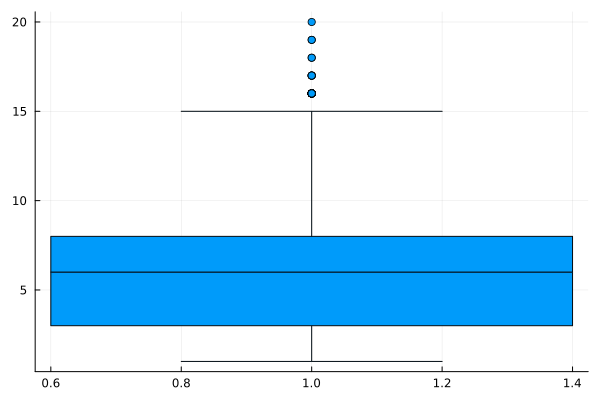

In [8]:
using StatsPlots
o = [6, 8, 3, 2, 3, 6, 7, 1, 2, 8, 4, 8, 4, 4, 2, 9, 6, 1, 8, 8, 2, 10, 8, 11, 8, 12, 4, 6, 8, 14, 4, 4, 3, 13, 1, 8, 3, 8, 12, 2, 11, 10, 2, 14, 2, 14, 14, 6, 6, 4, 7, 17, 12, 6, 7, 8, 4, 8, 8, 2, 2, 2, 6, 4, 3, 2, 8, 4, 3, 2, 16, 3, 8, 4, 6, 3, 2, 2, 8, 6, 12, 2, 4, 8, 2, 6, 2, 4, 10, 7, 7, 16, 3, 2, 6, 4, 2, 5, 8, 4, 2, 16, 4, 2, 7, 8, 6, 2, 5, 8, 4, 2, 10, 4, 14, 3, 6, 10, 4, 9, 3, 8, 8, 15, 4, 2, 4, 12, 4, 3, 12, 16, 4, 4, 9, 17, 6, 4, 8, 6, 2, 7, 4, 4, 8, 2, 6, 12, 8, 12, 2, 6, 2, 4, 8, 4, 8, 4, 4, 12, 6, 4, 10, 8, 12, 3, 14, 10, 4, 8, 2, 4, 8, 9, 2, 15, 6, 12, 5, 4, 11, 8, 4, 10, 2, 6, 2, 6, 3, 6, 4, 3, 6, 4, 3, 12, 4, 5, 1, 10, 12, 11, 8, 12, 1, 3, 2, 16, 4, 4, 14, 7, 8, 12, 12, 2, 3, 6, 9, 6, 6, 16, 2, 9, 6, 6, 3, 8, 1, 10, 2, 16, 10, 6, 4, 5, 4, 2, 8, 7, 7, 2, 14, 6, 2, 10, 4, 5, 4, 15, 2, 6, 4, 8, 8, 8, 8, 2, 8, 7, 2, 2, 8, 6, 8, 4, 10, 15, 10, 2, 4, 4, 3, 2, 8, 9, 4, 3, 2, 4, 4, 6, 2, 4, 6, 2, 6, 3, 6, 14, 7, 2, 2, 4, 5, 5, 12, 7, 4, 4, 4, 12, 4, 2, 6, 7, 4, 3, 2, 8, 3, 2, 4, 14, 2, 14, 4, 12, 6, 6, 7, 4, 4, 2, 6, 8, 8, 14, 2, 8, 1, 4, 2, 4, 2, 9, 4, 1, 1, 6, 1, 3, 9, 3, 8, 6, 2, 8, 8, 2, 2, 10, 10, 4, 15, 4, 4, 4, 9, 7, 6, 3, 1, 1, 15, 3, 4, 2, 12, 2, 2, 6, 2, 8, 3, 3, 12, 3, 14, 2, 6, 7, 6, 4, 4, 2, 2, 2, 6, 3, 14, 7, 8, 12, 8, 4, 6, 4, 4, 8, 2, 11, 14, 7, 4, 3, 12, 4, 9, 8, 6, 10, 7, 2, 2, 4, 12, 3, 12, 4, 2, 2, 6, 4, 8, 4, 3, 16, 4, 3, 16, 4, 14, 2, 2, 5, 4, 6, 7, 11, 8, 16, 4, 2, 4, 6, 4, 8, 2, 9, 2, 8, 10, 6, 12, 4, 2, 12, 2, 4, 6, 10, 14, 2, 10, 6, 2, 2, 5, 4, 4, 12, 16, 4, 8, 2, 12, 6, 4, 8, 1, 8, 9, 3, 1, 1, 14, 6, 2, 8, 12, 3, 2, 3, 2, 4, 6, 2, 6, 1, 16, 2, 1, 2, 5, 6, 4, 8, 10, 4, 3, 12, 15, 6, 4, 12, 4, 12, 7, 3, 7, 12, 8, 4, 2, 7, 1, 2, 3, 7, 4, 2, 4, 6, 6, 4, 1, 9, 2, 2, 1, 8, 8, 3, 4, 14, 3, 6, 8, 2, 15, 1, 4, 12, 8, 6, 10, 4, 1, 11, 6, 4, 10, 1, 12, 8, 7, 2, 12, 2, 4, 10, 6, 4, 8, 10, 5, 6, 8, 17, 3, 8, 7, 1, 4, 4, 10, 4, 1, 12, 4, 3, 4, 2, 2, 6, 8, 4, 6, 8, 6, 5, 8, 4, 8, 4, 2, 3, 6, 15, 14, 11, 16, 14, 8, 4, 4, 4, 4, 1, 7, 2, 6, 8, 12, 4, 2, 3, 6, 11, 6, 3, 2, 3, 1, 4, 6, 6, 7, 3, 6, 2, 2, 12, 4, 8, 5, 4, 12, 12, 2, 3, 10, 3, 4, 2, 3, 12, 6, 11, 10, 2, 6, 4, 4, 4, 4, 7, 8, 12, 2, 6, 4, 6, 4, 2, 2, 4, 16, 2, 12, 2, 9, 13, 4, 8, 4, 14, 3, 10, 14, 2, 4, 6, 12, 7, 3, 2, 4, 4, 4, 6, 8, 2, 8, 2, 7, 7, 4, 8, 8, 2, 8, 3, 4, 11, 1, 4, 2, 8, 8, 1, 14, 8, 2, 16, 7, 7, 16, 6, 7, 3, 8, 6, 8, 6, 8, 7, 3, 2, 8, 4, 4, 6, 6, 6, 4, 6, 8, 12, 12, 16, 4, 4, 8, 6, 3, 4, 2, 4, 12, 12, 4, 2, 3, 3, 8, 7, 8, 6, 12, 4, 12, 6, 10, 1, 2, 14, 2, 2, 3, 4, 1, 7, 6, 2, 8, 12, 4, 8, 8, 2, 10, 6, 4, 7, 4, 8, 8, 11, 2, 6, 6, 2, 1, 2, 13, 1, 4, 4, 8, 8, 19, 8, 6, 8, 1, 5, 1, 8, 8, 12, 2, 8, 5, 5, 1, 6, 3, 10, 2, 4, 8, 2, 6, 2, 3, 4, 8, 2, 1, 8, 12, 4, 3, 2, 8, 10, 5, 6, 14, 7, 7, 6, 4, 12, 8, 2, 4, 2, 12, 11, 8, 2, 10, 3, 14, 8, 5, 8, 4, 4, 8, 8, 2, 10, 3, 3, 11, 1, 8, 3, 4, 8, 8, 5, 8, 4, 3, 8, 1, 12, 2, 4, 6, 9, 4, 4, 2, 12, 4, 4, 6, 4, 12, 8, 9, 15, 4, 3, 3, 4, 14, 5, 8, 4, 9, 2, 8, 4, 8, 10, 4, 2, 8, 2, 8, 7, 10, 3, 1, 4, 6, 4, 4, 2, 2, 4, 3, 16, 4, 8, 6, 1, 8, 4, 8, 14, 3, 8, 4, 1, 9, 7, 7, 14, 14, 14, 1, 1, 12, 4, 8, 6, 8, 2, 8, 2, 8, 19, 2, 8, 8, 4, 2, 5, 7, 2, 4, 4, 13, 2, 4, 2, 2, 8, 4, 4, 4, 7, 4, 4, 6, 8, 1, 1, 2, 13, 6, 4, 10, 12, 2, 14, 2, 4, 4, 1, 3, 2, 12, 1, 2, 8, 6, 4, 6, 2, 6, 4, 13, 7, 10, 2, 7, 4, 8, 4, 4, 6, 12, 6, 4, 6, 6, 14, 3, 4, 8, 1, 8, 4, 13, 7, 6, 4, 7, 14, 1, 6, 4, 2, 14, 6, 6, 1, 12, 13, 1, 4, 2, 6, 8, 4, 2, 4, 8, 4, 6, 8, 7, 6, 7, 12, 12, 8, 7, 6, 6, 14, 8, 7, 3, 4, 2, 4, 4, 2, 4, 1, 8, 4, 14, 3, 18, 9, 2, 15, 2, 7, 4, 4, 7, 6, 2, 6, 2, 6, 4, 3, 8, 7, 12, 1, 7, 3, 6, 3, 4, 2, 7, 4, 12, 8, 8, 8, 8, 7, 3, 10, 4, 4, 8, 7, 3, 3, 8, 9, 1, 4, 6, 10, 1, 8, 6, 4, 4, 4, 4, 6, 6, 8, 4, 4, 1, 20, 8, 4, 11, 7, 14, 7, 4, 6, 4, 4, 8, 12, 3, 4, 3, 2, 1, 10, 10, 14, 8, 1, 8, 2, 4, 14, 8, 4, 12, 4, 3, 15, 10, 10, 4, 2, 9, 8, 8, 14, 8, 6, 1, 6, 4, 6, 4, 6, 12, 6, 1, 7, 8, 11, 2, 6, 1, 1, 2, 3, 2, 8, 2, 3, 6, 4, 2, 4, 1, 2, 3, 7, 6, 3, 14, 4, 12, 7, 7, 2, 8, 6, 6, 8, 4, 17, 2, 4, 4, 4, 7, 2, 6, 8, 6, 3, 12, 15, 7, 5, 8, 4, 2, 7, 6, 2, 4, 6, 9, 2, 12, 14, 4, 12, 5, 3, 4, 8, 6, 2, 5, 2, 6, 12, 3, 8, 2, 4, 6, 8, 4, 6, 11, 3, 6, 6, 7, 2, 7, 3, 8, 12, 10, 4, 2, 4, 8, 4, 15, 12, 8, 4, 7, 8, 6, 1, 2, 1, 3, 14, 8, 2, 2, 12, 11, 2, 1, 1, 8, 2, 3, 4, 2, 4, 8, 15, 12, 6, 12, 16, 6, 4, 4, 1, 4, 1, 8, 15, 6, 6, 1, 7, 7, 1, 6, 2, 4, 6, 4, 4, 12, 2, 4, 5, 4, 2, 8, 7, 8, 4, 6, 17, 8, 4, 4, 6, 8, 8, 3, 4, 12, 6, 4, 8, 7, 6, 12, 10, 5, 3, 9, 2, 4, 3, 4, 6, 8, 2, 6, 8, 6, 2, 4, 4, 9, 14, 3, 11, 8, 2, 12, 6, 2, 6, 4, 2, 4, 9, 13, 2, 8, 12, 4, 4, 3, 3, 8, 8, 8, 4, 15, 11, 4, 4, 4, 4, 2, 14, 8, 2, 2, 4, 4, 6, 6, 14, 2, 4, 4, 12, 4, 8, 4, 4, 2, 1, 3, 2, 2, 1, 7, 4, 1, 8, 2, 2, 8, 4, 4, 4, 14, 4, 6, 4, 2, 6, 4, 2, 10, 7, 2, 7, 4, 1, 8, 8, 4, 7, 8, 7, 12, 8, 8, 6, 6, 2, 4, 8, 4, 14, 7, 1, 8, 4, 11, 1, 8, 8, 6, 3, 10, 4, 7, 8, 7, 1, 6, 8, 14, 4, 7, 2, 4, 8, 4, 3, 2, 8, 6, 8, 8, 6, 4, 11, 4, 2, 1, 9, 6, 8, 8, 4, 4, 3, 6, 8, 2, 6, 2, 4, 2, 8, 2, 8, 12, 12, 8, 16, 2, 6, 4, 6, 2, 7, 4, 3, 14, 3, 8, 4, 8, 9, 3, 5, 2, 6, 2, 4, 12, 8, 4, 4, 3, 6, 4, 8, 1, 8, 8, 2, 2, 2, 4, 1, 4, 4, 6, 2, 3, 4, 16, 6, 6, 3, 4, 8, 4, 3, 8, 4, 4, 18, 8, 8, 2, 10, 8, 7, 2, 11, 1, 8, 11, 6, 1, 6, 3, 2, 12, 2]
boxplot(o,label="")

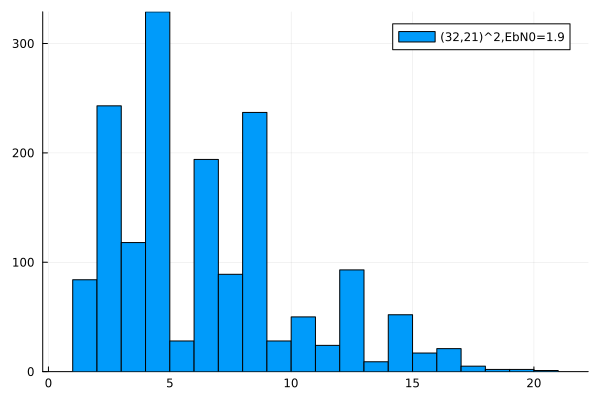

In [11]:
using Plots
o = [6, 8, 3, 2, 3, 6, 7, 1, 2, 8, 4, 8, 4, 4, 2, 9, 6, 1, 8, 8, 2, 10, 8, 11, 8, 12, 4, 6, 8, 14, 4, 4, 3, 13, 1, 8, 3, 8, 12, 2, 11, 10, 2, 14, 2, 14, 14, 6, 6, 4, 7, 17, 12, 6, 7, 8, 4, 8, 8, 2, 2, 2, 6, 4, 3, 2, 8, 4, 3, 2, 16, 3, 8, 4, 6, 3, 2, 2, 8, 6, 12, 2, 4, 8, 2, 6, 2, 4, 10, 7, 7, 16, 3, 2, 6, 4, 2, 5, 8, 4, 2, 16, 4, 2, 7, 8, 6, 2, 5, 8, 4, 2, 10, 4, 14, 3, 6, 10, 4, 9, 3, 8, 8, 15, 4, 2, 4, 12, 4, 3, 12, 16, 4, 4, 9, 17, 6, 4, 8, 6, 2, 7, 4, 4, 8, 2, 6, 12, 8, 12, 2, 6, 2, 4, 8, 4, 8, 4, 4, 12, 6, 4, 10, 8, 12, 3, 14, 10, 4, 8, 2, 4, 8, 9, 2, 15, 6, 12, 5, 4, 11, 8, 4, 10, 2, 6, 2, 6, 3, 6, 4, 3, 6, 4, 3, 12, 4, 5, 1, 10, 12, 11, 8, 12, 1, 3, 2, 16, 4, 4, 14, 7, 8, 12, 12, 2, 3, 6, 9, 6, 6, 16, 2, 9, 6, 6, 3, 8, 1, 10, 2, 16, 10, 6, 4, 5, 4, 2, 8, 7, 7, 2, 14, 6, 2, 10, 4, 5, 4, 15, 2, 6, 4, 8, 8, 8, 8, 2, 8, 7, 2, 2, 8, 6, 8, 4, 10, 15, 10, 2, 4, 4, 3, 2, 8, 9, 4, 3, 2, 4, 4, 6, 2, 4, 6, 2, 6, 3, 6, 14, 7, 2, 2, 4, 5, 5, 12, 7, 4, 4, 4, 12, 4, 2, 6, 7, 4, 3, 2, 8, 3, 2, 4, 14, 2, 14, 4, 12, 6, 6, 7, 4, 4, 2, 6, 8, 8, 14, 2, 8, 1, 4, 2, 4, 2, 9, 4, 1, 1, 6, 1, 3, 9, 3, 8, 6, 2, 8, 8, 2, 2, 10, 10, 4, 15, 4, 4, 4, 9, 7, 6, 3, 1, 1, 15, 3, 4, 2, 12, 2, 2, 6, 2, 8, 3, 3, 12, 3, 14, 2, 6, 7, 6, 4, 4, 2, 2, 2, 6, 3, 14, 7, 8, 12, 8, 4, 6, 4, 4, 8, 2, 11, 14, 7, 4, 3, 12, 4, 9, 8, 6, 10, 7, 2, 2, 4, 12, 3, 12, 4, 2, 2, 6, 4, 8, 4, 3, 16, 4, 3, 16, 4, 14, 2, 2, 5, 4, 6, 7, 11, 8, 16, 4, 2, 4, 6, 4, 8, 2, 9, 2, 8, 10, 6, 12, 4, 2, 12, 2, 4, 6, 10, 14, 2, 10, 6, 2, 2, 5, 4, 4, 12, 16, 4, 8, 2, 12, 6, 4, 8, 1, 8, 9, 3, 1, 1, 14, 6, 2, 8, 12, 3, 2, 3, 2, 4, 6, 2, 6, 1, 16, 2, 1, 2, 5, 6, 4, 8, 10, 4, 3, 12, 15, 6, 4, 12, 4, 12, 7, 3, 7, 12, 8, 4, 2, 7, 1, 2, 3, 7, 4, 2, 4, 6, 6, 4, 1, 9, 2, 2, 1, 8, 8, 3, 4, 14, 3, 6, 8, 2, 15, 1, 4, 12, 8, 6, 10, 4, 1, 11, 6, 4, 10, 1, 12, 8, 7, 2, 12, 2, 4, 10, 6, 4, 8, 10, 5, 6, 8, 17, 3, 8, 7, 1, 4, 4, 10, 4, 1, 12, 4, 3, 4, 2, 2, 6, 8, 4, 6, 8, 6, 5, 8, 4, 8, 4, 2, 3, 6, 15, 14, 11, 16, 14, 8, 4, 4, 4, 4, 1, 7, 2, 6, 8, 12, 4, 2, 3, 6, 11, 6, 3, 2, 3, 1, 4, 6, 6, 7, 3, 6, 2, 2, 12, 4, 8, 5, 4, 12, 12, 2, 3, 10, 3, 4, 2, 3, 12, 6, 11, 10, 2, 6, 4, 4, 4, 4, 7, 8, 12, 2, 6, 4, 6, 4, 2, 2, 4, 16, 2, 12, 2, 9, 13, 4, 8, 4, 14, 3, 10, 14, 2, 4, 6, 12, 7, 3, 2, 4, 4, 4, 6, 8, 2, 8, 2, 7, 7, 4, 8, 8, 2, 8, 3, 4, 11, 1, 4, 2, 8, 8, 1, 14, 8, 2, 16, 7, 7, 16, 6, 7, 3, 8, 6, 8, 6, 8, 7, 3, 2, 8, 4, 4, 6, 6, 6, 4, 6, 8, 12, 12, 16, 4, 4, 8, 6, 3, 4, 2, 4, 12, 12, 4, 2, 3, 3, 8, 7, 8, 6, 12, 4, 12, 6, 10, 1, 2, 14, 2, 2, 3, 4, 1, 7, 6, 2, 8, 12, 4, 8, 8, 2, 10, 6, 4, 7, 4, 8, 8, 11, 2, 6, 6, 2, 1, 2, 13, 1, 4, 4, 8, 8, 19, 8, 6, 8, 1, 5, 1, 8, 8, 12, 2, 8, 5, 5, 1, 6, 3, 10, 2, 4, 8, 2, 6, 2, 3, 4, 8, 2, 1, 8, 12, 4, 3, 2, 8, 10, 5, 6, 14, 7, 7, 6, 4, 12, 8, 2, 4, 2, 12, 11, 8, 2, 10, 3, 14, 8, 5, 8, 4, 4, 8, 8, 2, 10, 3, 3, 11, 1, 8, 3, 4, 8, 8, 5, 8, 4, 3, 8, 1, 12, 2, 4, 6, 9, 4, 4, 2, 12, 4, 4, 6, 4, 12, 8, 9, 15, 4, 3, 3, 4, 14, 5, 8, 4, 9, 2, 8, 4, 8, 10, 4, 2, 8, 2, 8, 7, 10, 3, 1, 4, 6, 4, 4, 2, 2, 4, 3, 16, 4, 8, 6, 1, 8, 4, 8, 14, 3, 8, 4, 1, 9, 7, 7, 14, 14, 14, 1, 1, 12, 4, 8, 6, 8, 2, 8, 2, 8, 19, 2, 8, 8, 4, 2, 5, 7, 2, 4, 4, 13, 2, 4, 2, 2, 8, 4, 4, 4, 7, 4, 4, 6, 8, 1, 1, 2, 13, 6, 4, 10, 12, 2, 14, 2, 4, 4, 1, 3, 2, 12, 1, 2, 8, 6, 4, 6, 2, 6, 4, 13, 7, 10, 2, 7, 4, 8, 4, 4, 6, 12, 6, 4, 6, 6, 14, 3, 4, 8, 1, 8, 4, 13, 7, 6, 4, 7, 14, 1, 6, 4, 2, 14, 6, 6, 1, 12, 13, 1, 4, 2, 6, 8, 4, 2, 4, 8, 4, 6, 8, 7, 6, 7, 12, 12, 8, 7, 6, 6, 14, 8, 7, 3, 4, 2, 4, 4, 2, 4, 1, 8, 4, 14, 3, 18, 9, 2, 15, 2, 7, 4, 4, 7, 6, 2, 6, 2, 6, 4, 3, 8, 7, 12, 1, 7, 3, 6, 3, 4, 2, 7, 4, 12, 8, 8, 8, 8, 7, 3, 10, 4, 4, 8, 7, 3, 3, 8, 9, 1, 4, 6, 10, 1, 8, 6, 4, 4, 4, 4, 6, 6, 8, 4, 4, 1, 20, 8, 4, 11, 7, 14, 7, 4, 6, 4, 4, 8, 12, 3, 4, 3, 2, 1, 10, 10, 14, 8, 1, 8, 2, 4, 14, 8, 4, 12, 4, 3, 15, 10, 10, 4, 2, 9, 8, 8, 14, 8, 6, 1, 6, 4, 6, 4, 6, 12, 6, 1, 7, 8, 11, 2, 6, 1, 1, 2, 3, 2, 8, 2, 3, 6, 4, 2, 4, 1, 2, 3, 7, 6, 3, 14, 4, 12, 7, 7, 2, 8, 6, 6, 8, 4, 17, 2, 4, 4, 4, 7, 2, 6, 8, 6, 3, 12, 15, 7, 5, 8, 4, 2, 7, 6, 2, 4, 6, 9, 2, 12, 14, 4, 12, 5, 3, 4, 8, 6, 2, 5, 2, 6, 12, 3, 8, 2, 4, 6, 8, 4, 6, 11, 3, 6, 6, 7, 2, 7, 3, 8, 12, 10, 4, 2, 4, 8, 4, 15, 12, 8, 4, 7, 8, 6, 1, 2, 1, 3, 14, 8, 2, 2, 12, 11, 2, 1, 1, 8, 2, 3, 4, 2, 4, 8, 15, 12, 6, 12, 16, 6, 4, 4, 1, 4, 1, 8, 15, 6, 6, 1, 7, 7, 1, 6, 2, 4, 6, 4, 4, 12, 2, 4, 5, 4, 2, 8, 7, 8, 4, 6, 17, 8, 4, 4, 6, 8, 8, 3, 4, 12, 6, 4, 8, 7, 6, 12, 10, 5, 3, 9, 2, 4, 3, 4, 6, 8, 2, 6, 8, 6, 2, 4, 4, 9, 14, 3, 11, 8, 2, 12, 6, 2, 6, 4, 2, 4, 9, 13, 2, 8, 12, 4, 4, 3, 3, 8, 8, 8, 4, 15, 11, 4, 4, 4, 4, 2, 14, 8, 2, 2, 4, 4, 6, 6, 14, 2, 4, 4, 12, 4, 8, 4, 4, 2, 1, 3, 2, 2, 1, 7, 4, 1, 8, 2, 2, 8, 4, 4, 4, 14, 4, 6, 4, 2, 6, 4, 2, 10, 7, 2, 7, 4, 1, 8, 8, 4, 7, 8, 7, 12, 8, 8, 6, 6, 2, 4, 8, 4, 14, 7, 1, 8, 4, 11, 1, 8, 8, 6, 3, 10, 4, 7, 8, 7, 1, 6, 8, 14, 4, 7, 2, 4, 8, 4, 3, 2, 8, 6, 8, 8, 6, 4, 11, 4, 2, 1, 9, 6, 8, 8, 4, 4, 3, 6, 8, 2, 6, 2, 4, 2, 8, 2, 8, 12, 12, 8, 16, 2, 6, 4, 6, 2, 7, 4, 3, 14, 3, 8, 4, 8, 9, 3, 5, 2, 6, 2, 4, 12, 8, 4, 4, 3, 6, 4, 8, 1, 8, 8, 2, 2, 2, 4, 1, 4, 4, 6, 2, 3, 4, 16, 6, 6, 3, 4, 8, 4, 3, 8, 4, 4, 18, 8, 8, 2, 10, 8, 7, 2, 11, 1, 8, 11, 6, 1, 6, 3, 2, 12, 2]
histogram(o,label="(32,21)^2,EbN0=1.9")

In [13]:
sum(o)/length(o)

6.033210332103321

In [37]:
N = 32; K = 21
args = (N,K,100,20,0.5)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,3.0)
@time res = solver(10000,t,awgn)
println(res)

 48.396470 seconds (12 allocations: 327.250 KiB)
(0.4125, 0.00035056689342403627, 9042, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
N = 32; K = 21
args = (N,K,100,20,0.5)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,3.0)
@time res = solver(10000,t,awgn)
println(res)

 52.350302 seconds (12 allocations: 327.250 KiB)
(0.4125, 0.00035056689342403627, 9042, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
println(res[4])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

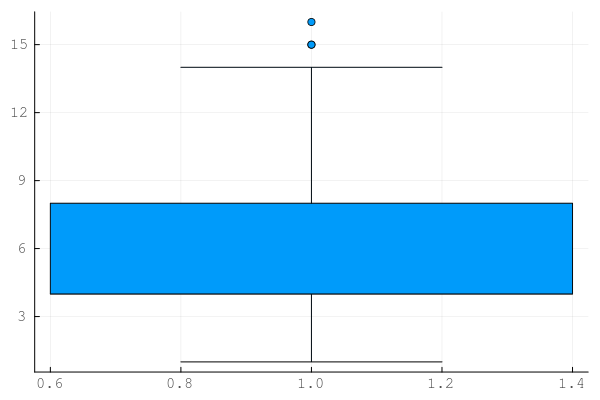

In [31]:
using StatsPlots
e = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 7, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 4, 0, 0, 0, 1, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
N = 32; K = 21
args = (N,K,100,20,0.5)
default(fontfamily="MS Gothic")
boxplot(filter(!iszero,e),label="")

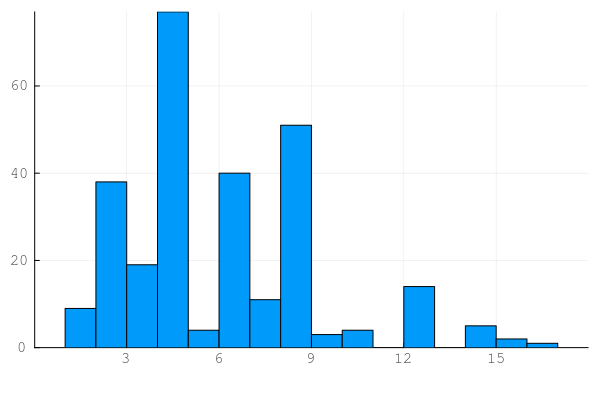

GKS: glyph missing from current font: 12456
GKS: glyph missing from current font: 12521
GKS: glyph missing from current font: 12540
GKS: glyph missing from current font: 12398
GKS: glyph missing from current font: 20491
GKS: glyph missing from current font: 25968
GKS: invalid bitmap size


In [36]:
using Plots
default(fontfamily="MS Gothic")
histogram(filter(!isequal(0),e),bins=20,label="",xlabel="エラーの個数",xlabelfontsize=20)

In [307]:
N = 32; K = 21
args = (N,K,100,20,0.5)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,3.0)
@time res = solver(10000,t,awgn)
println(res)

 49.766165 seconds (12 allocations: 327.250 KiB)
(0.5377, 0.00035056689342403627, 9042, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [295]:
N = 32; K = 21
args = (N,K,100,20,0.6)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,3.0)
@time res = solver(1000,t,awgn)
println(res)

  3.179468 seconds (3 allocations: 704 bytes)
(0.358, 9.297052154195012e-5, 973)


In [268]:
N = 16; K = 10
args = (N,K,100,20,0.6)
t = ProdBPProblem(args...)
awgn = AWGN(N*N,K*K,8,3.5)
@time res = solver(2,t,awgn)
println(res)

  0.000297 seconds (5 allocations: 560 bytes)
(0.5, [2])


In [272]:
filter(i->>(0.0,t.Lapp[i]),1:256)

4-element Vector{Int64}:
 39
 55
 71
 87

In [73]:
N = 32; K = 21
arg = (N,K,10,1,0.5)
t = ProdBPProblem(arg...)
awgn = AWGN(N*N,K*K,8,3)
bler = solver(1,t,awgn)
println("BLER: $bler")

  0.000330 seconds (64 allocations: 1024 bytes)
  0.000203 seconds (64 allocations: 1024 bytes)
BLER: 1.0


In [55]:
filter(<(0.0),t.Lapp)

8-element Vector{Float64}:
 -2.795108806646322
 -2.6046183091550805
 -1.266011265023157
 -2.162826751116429
 -0.3740645923149727
 -0.2787438836064866
 -1.535732725074039
 -1.5242632810876402

# updateLch_plus_La!

In [ ]:
function updateLch_plus_La!(Lch_plus_a,Lch,La)
    for i in eachindex(Lch_plus_a)
        Lch_plus_a[i] = Lch[i] + La[i]
    end
end
N = 32
Lch = randn(N,N)
La = zeros(N,N)
Lch_plus_a = zeros(N,N)

In [55]:
updateLch_plus_La!(Lch_plus_a,Lch,La)
Lch_plus_a == Lch ? println("success") : println("error")

success


# updateLeandLa!

In [270]:
function updateLeandLa!(i,j,Lapp,Lch,La,Le,alpha)
    @views if i > 0 && j == 0
        for k in eachindex(Le[i,:])
            Le[i,k] = Lapp[i,k] - Lch[i,k] - La[i,k]
            La[i,k] = alpha*Le[i,k]
        end
    elseif i == 0  && j > 0
        for k in eachindex(Le[:,j])
            Le[k,j] = Lapp[k,j] - Lch[k,j] - La[k,j]
            La[k,j] = alpha*Le[k,j]
        end
    else 
        nothing
    end
    nothing
end
N = 4; alpha = 0.5
Lapp = rand(N,N)
La = rand(N,N)
Le = rand(N,N)
Lch = rand(N,N)
nothing

In [280]:
@time updateLeandLa!(2,0,Lapp,Lch,La,Le,alpha)

  0.000005 seconds


In [209]:
p = 0.0003
N=32
1-(1-p)^N

0.009555493629211598

# isnothing()を使ったBP復号終了判定
- すべてtrueなら成功、一つでもfalseなら失敗

In [1]:
isnothing(findfirst(isequal(true),[false,true]))

false

# エネルギー対雑音密度(単位：dB)をSNR(単位：dB)に変換する関数

In [9]:
# eb[dB] r= K/N
ebtosnrdb(eb,r) = eb + 10log10(r)

ebtosnrdb (generic function with 1 method)

# LLR行列を生成する関数

In [41]:
using Random
function random_LLR(snrdb,args...;seed = 8)
    rng = MersenneTwister(seed)
    y = zeros(args...)
    @views for i in eachindex(y)
        x = -10^(snrdb/20) + sqrt(1/2) * randn(rng)
        y[i] = -4*x
    end
    y
end
snrdb = 0.3
random_LLR(snrdb,3,3)


3×3 Matrix{Float64}:
  4.16213  5.74496  2.89067
 -1.77322  7.68765  4.25783
 -2.47735  6.02161  2.33398

# 行列をLLRで埋める関数

In [11]:
function fillLLR!(rng,snrdb,llr)
    for i in eachindex(llr)
        y = -10^(snrdb/20) + sqrt(1/2)*randn(rng)
        llr[i] = -4*y*10^(snrdb/20)
    end
    nothing
end

using Random
N = 8
rng = MersenneTwister(8)
llr = zeros(N)
snrdb = 3.0+10*log10(1/2)
nothing

In [10]:
fillLLR!(rng,snrdb,llr)
llr'

1×8 adjoint(::Vector{Float64}) with eltype Float64:
 12.6875  2.13275  0.880594  15.5022  18.9568  15.9941  10.4265  12.8576

# LLRが0以下ものがあれがfalseを返す関数

In [152]:
iserror(Lapp) = isnothing(findfirst(<=(0.0),Lapp))

iserror (generic function with 1 method)

In [171]:
Lapp = rand(0:9,3,3) 
iserror(Lapp)

false

In [268]:
T = 100000
v = 1000*(rand(T).-0.5)
t = 1
R = 0.0
L = [0.0,0.0]
M = T-t
for i=1:T-t
    R += (v[i]*v[i+t])
end
for i=1:T-t
    L[1] += v[i]
    L[2] += v[i+t]
end
R/M |> println
(L[1]/M)*(L[2]/M) |> println

-149.77490658602227
0.0007474759168973397


# 構造体の使い方
- @unpack で構造体のフィールドを展開できる

In [1]:
using Parameters
struct Sample
    v::Int
    k::Float64
    z::Vector{Float64}
end

s = Sample(1,2.0,randn(8))
@unpack v,k,z = s


Sample(1, 2.0, [-0.34920521053861164, 0.7906828903037989, 0.4215940246085762, 0.6366030031471095, -1.7849142528016473, 1.0601244509229655, -0.08043389394781095, 1.208562833485096])

In [14]:
struct EMP; end
abstract type PEMP end

In [3]:
mutable struct NUM
    index::Int
end
k = NUM(8)
k.index = 100

NUM(100)

In [59]:
struct p; i::Int; end
for k in [p]
    println(k(9))
end
l() = 1
@time l()

p(9)
  0.000003 seconds


1

# 行列の要素を一つのインデックスだけで参照する

In [66]:
k = reshape(1:6,2,3)
display(k)
k[4]

2×3 reshape(::UnitRange{Int64}, 2, 3) with eltype Int64:
 1  3  5
 2  4  6

4

# 研究記録を取る

In [17]:
struct LOG
    filename::String
    data::String
end

function write_log(l::LOG)
    filename = l.filename
    open(filename,"a") do f
        println(f,l.data)
    end
end

write_log (generic function with 1 method)

In [18]:
a = LOG("../log/sample.txt","Hello World")
write_log(a)
println("sample.txt $(a.data)")

sample.txt Hello World


# グラフにキャプションを追加する

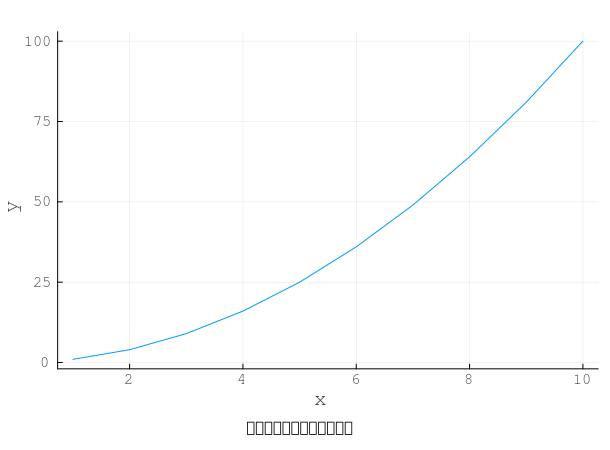

GKS: glyph missing from current font: 20108
GKS: glyph missing from current font: 27425
GKS: glyph missing from current font: 38306
GKS: glyph missing from current font: 25968
GKS: glyph missing from current font: 12398
GKS: glyph missing from current font: 35500
GKS: glyph missing from current font: 26126
GKS: glyph missing from current font: 12434
GKS: glyph missing from current font: 36861
GKS: glyph missing from current font: 21152
GKS: glyph missing from current font: 12377
GKS: glyph missing from current font: 12427
GKS: glyph missing from current font: 20108
GKS: glyph missing from current font: 27425
GKS: glyph missing from current font: 38306
GKS: glyph missing from current font: 25968
GKS: glyph missing from current font: 12398
GKS: glyph missing from current font: 35500
GKS: glyph missing from current font: 26126
GKS: glyph missing from current font: 12434
GKS: glyph missing from current font: 36861
GKS: glyph missing from current font: 21152
GKS: glyph missing from current 

In [19]:
using Plots
default(fontfamily="MS Gothic")
# データの準備
x = 1:10
y = x.^2

# グラフの作成
p = plot(x, y,
    title="二次関数のグラフ",
    xlabel="x軸",
    ylabel="y軸",
    legend=false,
    size=(610, 450); 
    bottom_margin=10*Plots.PlotMeasures.mm)  # 下部マージンを20mmに設定

# キャプションの追加
annotate!(5,-20,text("二次関数の説明を追加する",:center,10))

# グラフの表示
display(p)